In [1]:
import metmhn.Utilityfunctions as utils
import metmhn.regularized_optimization as reg_opt

import pandas as pd
import numpy as np
import jax as jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score, 
                             precision_recall_curve)
from sklearn.linear_model import LogisticRegression

Read the data and split it in  training and test sets:

In [2]:
annot_handle = "../data/paad/G13_PAADPANET_PM_v2_sampleSelection_30and15.csv"
mut_handle = "../data/paad/G13_PAADPANET_PM_v2_Events_30and15_Full.csv"

annot_data = pd.read_csv(annot_handle)
mut_data = pd.read_csv(mut_handle)
mut_data.rename(columns={"Unnamed: 0":"patientID"}, inplace = True)
dat = pd.merge(mut_data, annot_data.loc[:, ['patientID', 'metaStatus']], on=["patientID", "patientID"])

[Text(1, 0, 'NM'), Text(2, 0, 'PM')]

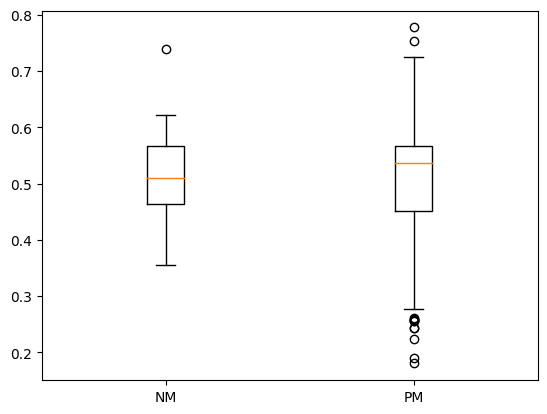

In [83]:
NMs = reg_opt.p_unobs_seeding(theta, fd_effects, jnp.array(test_po))
EMs = reg_opt.p_unobs_seeding(theta, fd_effects, jnp.array(test_pm))
probs = {"NM": NMs, "PM": EMs}
fig, ax = plt.subplots()
ax.boxplot(probs.values())
ax.set_xticklabels(probs.keys())

In [3]:
# Split the dataset into a training and a test set
muts = ['P.KRAS (M)', 'M.KRAS (M)', 'P.TP53 (M)', 'M.TP53 (M)',
       'P.SMAD4/18q (Del)', 'M.SMAD4/18q (Del)', 'P.MYC/8q (Amp)', 'M.MYC/8q (Amp)',
       'P.TP53/17p (Del)', 'M.TP53/17p (Del)', 'P.SMAD4 (M)', 'M.SMAD4 (M)', 
       'P.KRAS/12p (Amp)', 'M.KRAS/12p (Amp)', 'P.SETD2/3p (Del)', 'M.SETD2/3p (Del)',
       'P.MEN1/11q (Del)', 'M.MEN1/11q (Del)',
       'P.RNF43 (M)', 'M.RNF43 (M)', 'P.MEN1 (M)', 'M.MEN1 (M)', 
       'P.GNAS (M)', 'M.GNAS (M)', 'P.DAXX (M)', 'M.DAXX (M)', 'P.KMT2C (M)',
       'M.KMT2C (M)', 'P.ATM (M)', 'M.ATM (M)', 'P.RBM10 (M)', 'M.RBM10 (M)',
       'P.BRCA2 (M)', 'M.BRCA2 (M)', 'P.ATRX (M)', 'M.ATRX (M)',
       'P.PIK3CA (M)', 'M.PIK3CA (M)', 'P.SETD2 (M)', 'M.SETD2 (M)',
       'P.TGFBR1 (M)', 'M.TGFBR1 (M)', 'P.RB1 (M)', 'M.RB1 (M)',
       'P.SMARCA4 (M)', 'M.SMARCA4 (M)', 'P.SMAD3 (M)', 'M.SMAD3 (M)',
       'P.MAP2K4 (M)', 'M.MAP2K4 (M)', 'P.TSC2 (M)', 'M.TSC2 (M)',
       'P.BCOR (M)', 'M.BCOR (M)', 'P.STK11 (M)', 'M.STK11 (M)', 'P.U2AF1 (M)',
       'M.U2AF1 (M)', 'P.SF3B1 (M)', 'M.SF3B1 (M)', 'P.PTPRT (M)',
       'M.PTPRT (M)']
dat["type"] = dat.apply(utils.categorize, axis=1)
dat["Seeding"] = dat.apply(utils.add_seeding, axis=1)
events_data = muts+["Seeding"]
cleaned = dat.loc[dat["type"].isin([0,1,2,3]), muts+["Seeding", "type"]]

cleaned.drop(cleaned[cleaned.iloc[:,:-1].sum(axis=1)<1].index, inplace=True)
shuffled = cleaned.sample(frac=1)
n_dat = cleaned.shape[0]
# 80-20 train test split
train = shuffled.iloc[:int(0.8*n_dat), :]
train_po, train_pm, train_mo, train_c = utils.split_data(train, events_data)

test = shuffled.iloc[int(0.8*n_dat):, :]
test_labels = test.loc[test["type"].isin([0,1,3]), 'Seeding']
test = test.loc[test["type"].isin([0,1,3]), :]
test_po, test_pm, test_mo, test_c = utils.split_data(test, events_data)

Learn the metMHN:

In [76]:
penal = 1/180 #L1 penalty on off-diagonals
m_p_corr = 0.5
th_init, fd_init, sd_init = utils.indep(jnp.array(train[events_data].to_numpy()), train_c.shape[0])
theta, fd_effects, sd_effects = reg_opt.learn_mhn(th_init, fd_init, sd_init, train_po, train_pm, 
                                                  train_c, m_p_corr, jnp.ones(2), penal)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1088     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.70830D+00    |proj g|=  1.49684D+00


 This problem is unconstrained.



At iterate    1    f=  8.08658D+00    |proj g|=  8.61103D-01

At iterate    2    f=  7.38632D+00    |proj g|=  1.17632D-01

At iterate    3    f=  7.32686D+00    |proj g|=  6.89219D-02

At iterate    4    f=  7.20673D+00    |proj g|=  7.36643D-02

At iterate    5    f=  7.12153D+00    |proj g|=  9.64706D-02

At iterate    6    f=  7.03596D+00    |proj g|=  5.67847D-02

At iterate    7    f=  6.98069D+00    |proj g|=  2.66859D-02

At iterate    8    f=  6.95059D+00    |proj g|=  2.86834D-02

At iterate    9    f=  6.92768D+00    |proj g|=  2.49665D-02

At iterate   10    f=  6.90681D+00    |proj g|=  1.87056D-02

At iterate   11    f=  6.89054D+00    |proj g|=  3.09118D-02

At iterate   12    f=  6.87773D+00    |proj g|=  2.14637D-02

At iterate   13    f=  6.86827D+00    |proj g|=  1.96666D-02

At iterate   14    f=  6.85816D+00    |proj g|=  1.66302D-02

At iterate   15    f=  6.84721D+00    |proj g|=  1.88430D-02

At iterate   16    f=  6.83456D+00    |proj g|=  1.30606D-02

At iter

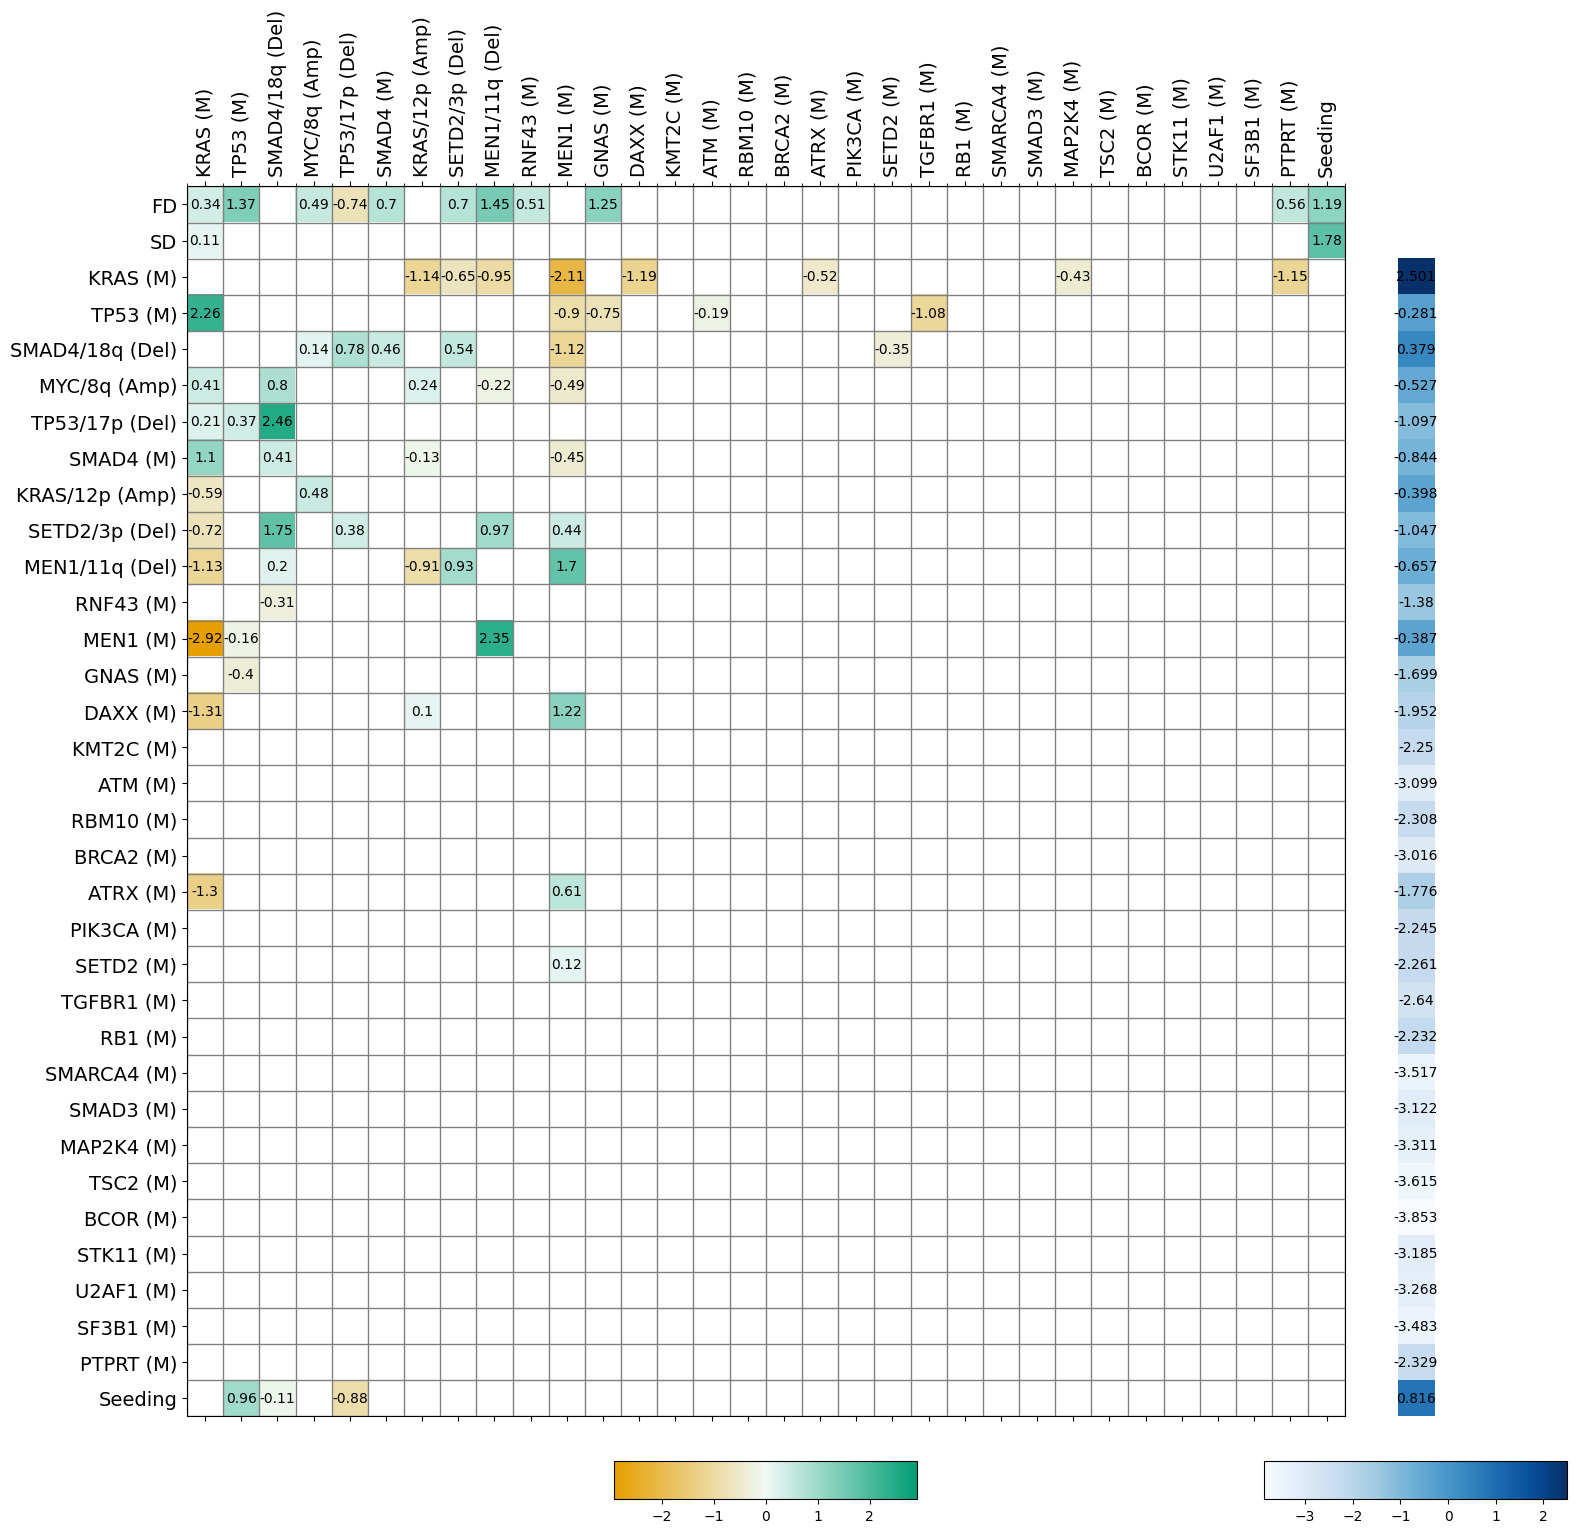

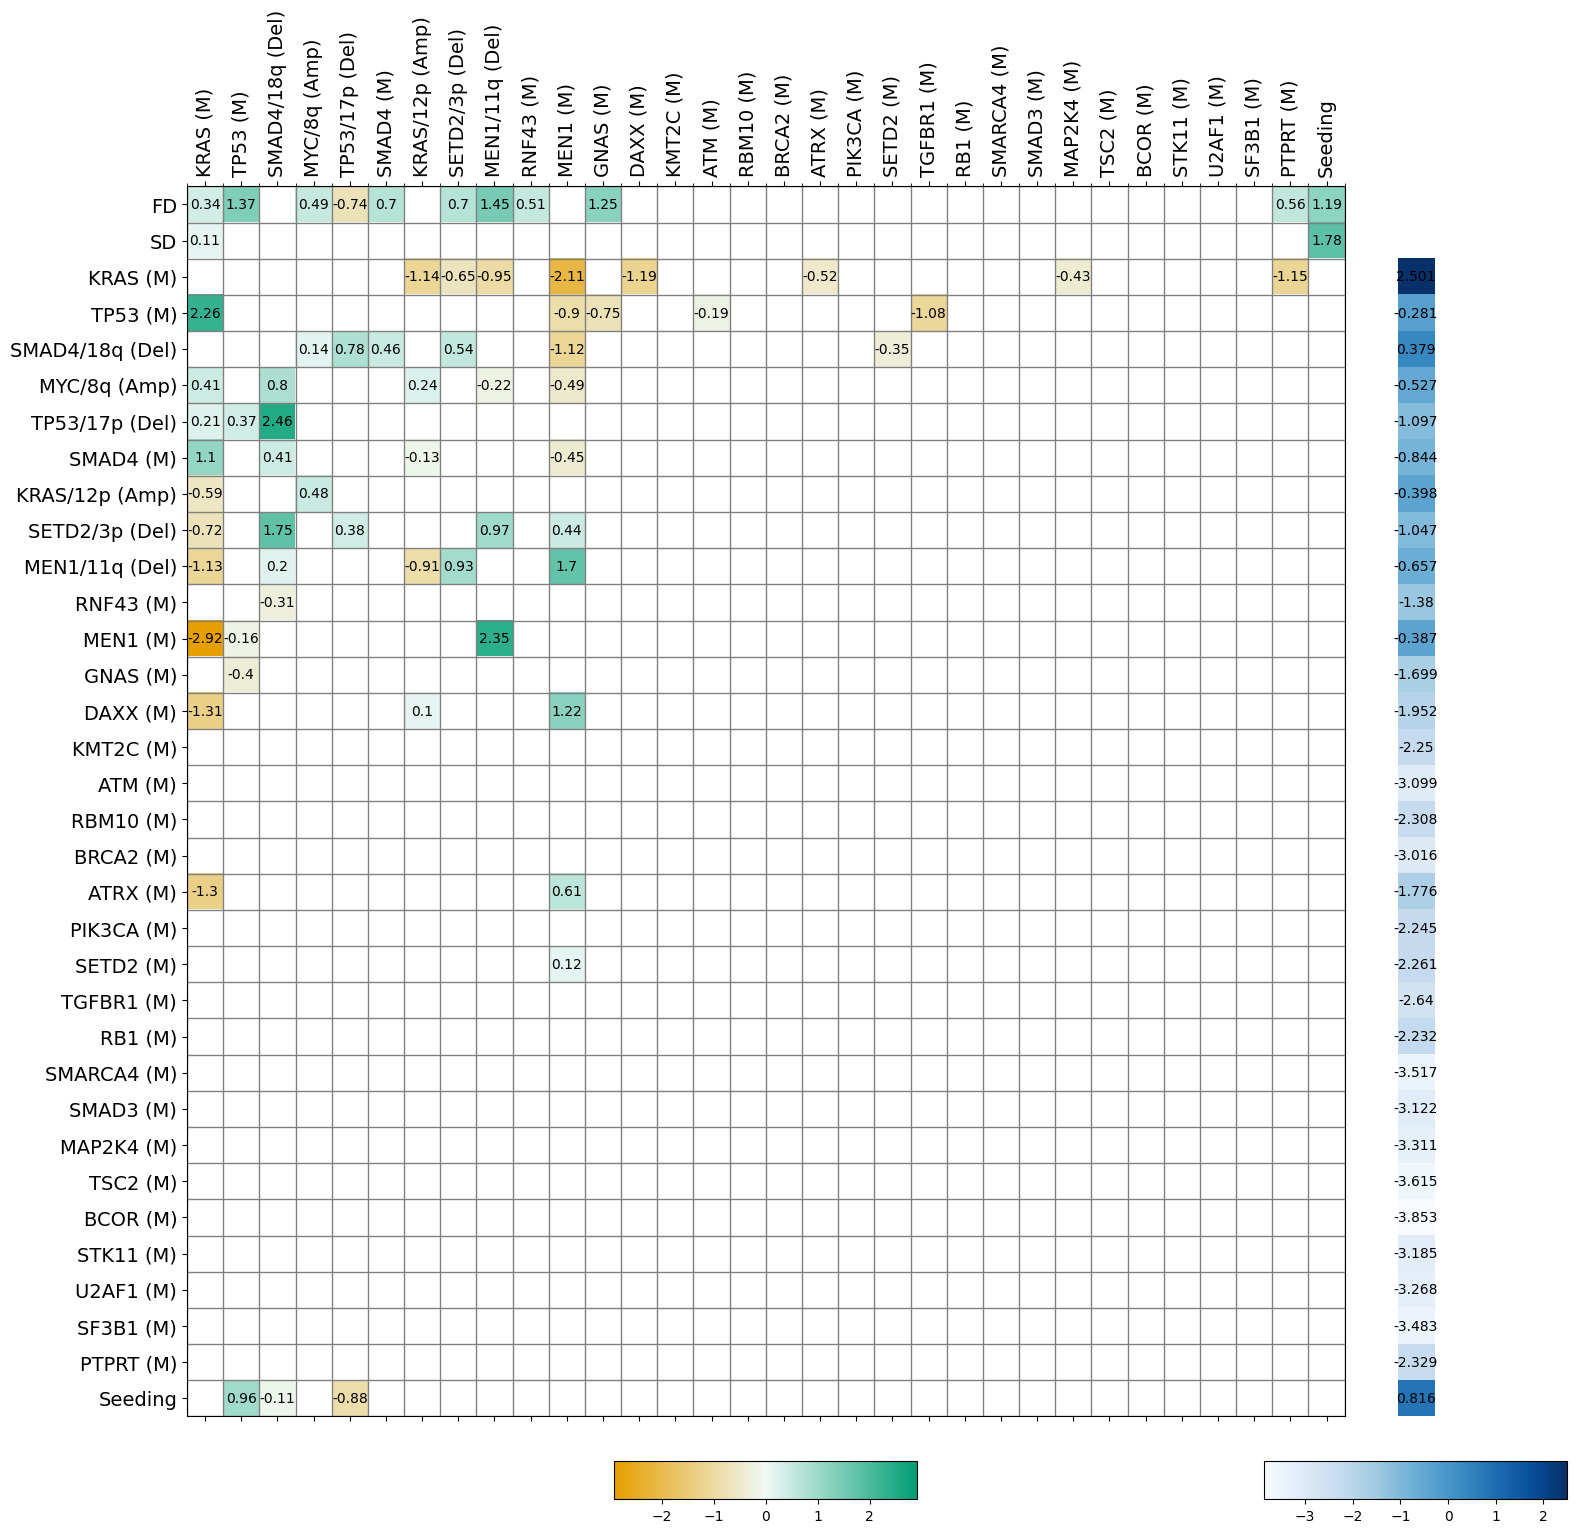

In [77]:
th_plot = np.row_stack((fd_effects, sd_effects, theta))
events_plot = []
for elem in cleaned.columns[:-2].to_list()[::2]:
    full_mut_id = elem.split(".")
    events_plot.append(full_mut_id[1])
events_plot.append("Seeding")
utils.plot_theta(th_plot, events_plot, 0.1)

In [78]:
df2 = pd.DataFrame(th_plot, columns=events_plot)
df2.to_csv("../results/luad/coupled_only_25m_5cnvs_01.csv")

Calculate the probability that a MT is present given the PT-genotype:

In [79]:
mhn_probs = reg_opt.p_unobs_seeding(theta, fd_effects, jnp.array(test[events_data].to_numpy()))

Learn a standard logistic regression model as baseline :

In [80]:
train_labels = train.loc[train["type"].isin([0,1,3]), 'Seeding']
train_reg = train.loc[train["type"].isin([0,1,3]), muts].to_numpy()
logReg = LogisticRegression(C=0.01, max_iter=1000)
# The log reg can't utilize sequences of mets
logReg.fit(train_reg[:,::2], train_labels)

test_reg = test[muts].to_numpy()
reg_probs = logReg.predict_proba(test_reg[:, ::2])

Compare both models:

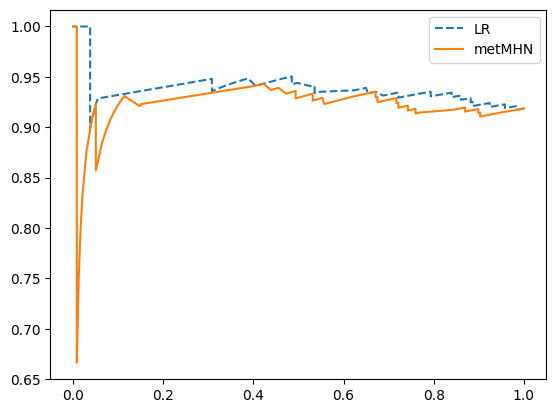

In [81]:
mhn_auc = roc_auc_score(test_labels, mhn_probs)
mhn_fpr, mhn_tpr, _ = roc_curve(test_labels, mhn_probs)
mhn_precision, mhn_recall, _ = precision_recall_curve(test_labels, mhn_probs)

reg_auc = roc_auc_score(test_labels, reg_probs[:,1])
reg_fpr, reg_tpr, _ = roc_curve(test_labels, reg_probs[:, 1])
reg_precision, reg_recall, _ = precision_recall_curve(test_labels, reg_probs[:,1])

plt.plot(reg_recall, reg_precision, linestyle="--", label="LR")
plt.plot(mhn_recall, mhn_precision, linestyle="-", label="metMHN")
plt.legend()

In [82]:
print(reg_auc, mhn_auc)

0.5994575045207957 0.5363672895318465
